In [1]:
import os
import tqdm
import torch
import random
import librosa
import torchaudio
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchaudio import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, Dataset,TensorDataset
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [2]:
# Get cpu, gpu or mps device for training.
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")


Using cuda device


DATA

In [3]:
class AudioDataset(Dataset):
    def __init__(self, data_dir, is_label, TARGET_SAMPLE_RATE = 16000):
        #is label = True para audios com label, False para audios sem label, isso garante que mudanças no pipeline de extração de features sejam para ambos os conjuntos
        self.data_dir = data_dir
        self.classes = ["real", "fake"]
        self.audio_files = []
        self.labels = []
        self.is_label = is_label
        self.TARGET_SAMPLE_RATE =TARGET_SAMPLE_RATE
        if self.is_label:
            for class_idx, class_name in enumerate(self.classes):
                class_dir = os.path.join(data_dir, class_name)
                for file in os.listdir(class_dir):
                    if file.endswith(".mp3"):
                        self.audio_files.append(os.path.join(class_dir, file))
                        self.labels.append(class_idx)
        else:            
            for file in os.listdir(self.data_dir):
                if file.endswith(".mp3"):
                    self.audio_files.append(os.path.join(self.data_dir,file))

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64
        )

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        if self.is_label:
            label = self.labels[idx]

        # Load audio
        audio, sr = torchaudio.load(audio_file)
        # Convert to mono
        if audio.shape[0] > 1:
            audio = torch.mean(audio, dim=0).unsqueeze(0)

        if sr != self.TARGET_SAMPLE_RATE:
            audio = torchaudio.transforms.Resample(sr, self.TARGET_SAMPLE_RATE)(audio)

        # Pad or truncate the audio to a fixed length
        fixed_length = (
            self.TARGET_SAMPLE_RATE * 3
        )  # Adjust this value based on your requirements
        if audio.shape[1] < fixed_length:
            audio = torch.nn.functional.pad(audio, (0, fixed_length - audio.shape[1]))
        else:
            audio = audio[:, :fixed_length]

        audio = self.mel_spectrogram(audio)
        if self.is_label:
            return audio, label
        else:
            #import for test generating
            return audio, os.path.basename(audio_file)

DataLoader

In [4]:
class Data:
   
    def __init__(self, batch_size,dataset_train,dataset_test, do_split):
        self.modes = ['train','test']
        self.dataloaders = {}
        self.batch_size = batch_size
        self.do_split = do_split
        if self.do_split:
            self.modes = ['train','validation','test']
            generator = torch.Generator().manual_seed(42)
            train_size = int(len(dataset_train.audio_files)*0.8)
            val_size = int(len(dataset_train.audio_files)-train_size)
            train_set, val_set = random_split(dataset_train, [train_size, val_size], generator=generator)

            self.dataloaders['train'] = train_set
            self.dataloaders['validation'] = val_set
        else:
            self.dataloaders['train'] = dataset_train
            
        self.dataloaders['test'] = dataset_test
    

    def get_loader(self, mode):
        if mode == 'train':
            return  DataLoader(self.dataloaders[mode], batch_size=self.batch_size, shuffle=True)
        else:
            return  DataLoader(self.dataloaders[mode], batch_size=self.batch_size, shuffle=False)


Evaluator

In [5]:
class Evaluator:
    
    def __init__(self):
    
        self.loss_fn = nn.BCELoss()
    def get_loss(self, y, y_hat):
        return self.loss_fn(y_hat, y)

Model

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.input_size = input_size
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        dummy_tensor = self.conv_layer(torch.zeros(self.input_size).unsqueeze(0))
        dim = 1
        for d in dummy_tensor.shape[1:]:
            dim *= d
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(dim, 1)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = torch.sigmoid(x)
        return x


Learner

In [7]:
class Learner:
    def __init__(self, input_size):
        self.model = NeuralNetwork(input_size=input_size)
        self.model.to(DEVICE)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def predict(self, x):
        return self.model(x)

    def update(self, loss):
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

Metrics e best models

In [8]:
class Metrics():
    #FOR TRAIN AND VALIDATION ONLY
    def __init__(self):
        self.metrics_save = {}
        self.best_models_weigths = {}
        self.metrics_names  = ['acuracy','recall','precision','f1-score']
        
    def calc_metrics(self,preds,labels,mode,loss, model_weigths=None, show=False):
        acc = accuracy_score(y_pred=preds, y_true=labels)
        recall = recall_score(y_pred=preds, y_true=labels)
        precision = precision_score(y_pred=preds, y_true=labels)
        f1 = f1_score(y_pred=preds, y_true=labels,average='binary')
        metrics_values = [acc,recall,precision,f1]


        ###################LOSS#############################################
        if f'{mode}_loss' not in self.metrics_save.keys():
            self.metrics_save[f'{mode}_loss'] = [loss]
        else:
            self.metrics_save[f'{mode}_loss'].append(loss)
        ################################################################
        
        if show:
            print(f"{mode} -  Acuracy: {acc:.2f} - Recall {recall:.2f} - Precision {precision:.2f} - F1-Score {f1:.2f} - Loss {loss:.2f}")


        #############Metrics##################################################
        
        for metric_name, metric_value in zip(self.metrics_names, metrics_values):

            ###Add metrics 
            if f'{mode}_{metric_name}' not in self.metrics_save.keys():
                self.metrics_save[f'{mode}_{metric_name}'] = [metric_value]
            else:
                self.metrics_save[f'{mode}_{metric_name}'].append(metric_value)
            
            ###Sava best metrics and respective weigths 
            if mode == 'train':
                if f'{mode}_best_{metric_name}' not in self.metrics_save.keys():
                    self.metrics_save[f'{mode}_best_{metric_name}'] = metric_value
                    self.best_models_weigths[f'{mode}_best_{metric_name}'] = model_weigths
                elif metric_value > self.metrics_save[f'{mode}_best_{metric_name}'] :
                    self.best_models_weigths[f'{mode}_best_{metric_name}'] = model_weigths
    
        ################################################################


    def plot_metrics(self):
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        metrics = self.metrics_names.copy()
        modes = ['train','validation']
        for i,metric_name in enumerate(metrics):
            metric_train  = self.metrics_save[f'{modes[0]}_{metric_name}']
            metric_validation  = self.metrics_save[f'{modes[1]}_{metric_name}']

            ii = i % 2
            jj = i // 2
            axs[jj,ii].plot(metric_train, label=modes[0])
            axs[jj,ii].plot(metric_validation, label=modes[1])

            axs[jj,ii].set_title(f'{metric_name}: {modes[0]} x {modes[1]}')
            axs[jj,ii].set_xlabel('Epoch')
            axs[jj,ii].set_ylabel(f'{metric_name}')
            axs[jj,ii].legend()

        plt.tight_layout()

        # Mostrar o plot
        plt.show()

    def plot_loss(self):
        modes = ['train','validation']
        metric_name = 'loss'
        metric_train  = np.exp(self.metrics_save[f'{modes[0]}_{metric_name}'])
        metric_validation  = np.exp(self.metrics_save[f'{modes[1]}_{metric_name}'])
        fig, axs = plt.subplots(1, 1, figsize=(6, 12))
        i = 0
        axs[i,i].set_title(f'Log scale {metric_name}: {modes[0]} x {modes[1]}')
        axs[i,i].plot(metric_train, label=modes[0])
        axs[i,i].plot(metric_validation, label=modes[1])
        axs[i,i].set_xlabel('Epoch')
        axs[i,i].set_ylabel(f'{metric_name}')
        axs[i,i].legend()

        plt.tight_layout()
        # Mostrar o plot
        plt.show()

    def get_best_model(self, metric):
        for key in self.best_models_weigths.keys():
                if metric in key:
                    return self.best_models_weigths[key]
    
    def save_best_model(self,all_metrics, metric='F1-Score'):
        if all_metrics:
            print("Saving all models")
            for key in self.best_models_weigths.keys():
                torch.save(f'{self.best_models_weigths[key]}.pt', key)
                print(f"Save model at: {key}.pt")

        else:
            print(f"Saving best model for {metric}")
            for key in self.best_models_weigths.keys():
                if metric in key:
                    torch.save(f'{self.best_models_weigths[key]}.pt', key)
                    print(f"Save model at: {key}.pt")
                    break


Trainer

In [9]:
class Trainer:
    def __init__(self, data: Data, learner: Learner, evaluator: Evaluator, metrics: Metrics):
        self.data = data
        self.learner = learner
        self.metrics = metrics
        self.evaluator = evaluator

    def one_epoch(self, mode):
        if mode == 'train':
            self.learner.model.train(True)
        else:
            self.learner.model.train(False)
    

        dataloader = self.data.get_loader(mode)
        preds = []
        labels = []
        epoch_loss = 0
        
        for (X, y) in tqdm.tqdm(dataloader):
            X, y = X.to(DEVICE), y.to(DEVICE).float().unsqueeze(1)

            y_hat = self.learner.predict(X)
            
            loss = self.evaluator.get_loss(y, y_hat)
            epoch_loss += loss.item()

            if mode == 'train':
                self.learner.update(loss)

            labels.extend(y.int().tolist())
            preds.extend((y_hat > 0.5).int().tolist())
        
        epoch_loss /= len(dataloader)

        #preds,labels,mode,loss, model_weigths=None, show=False
        self.metrics.calc_metrics(preds=preds, labels=labels, mode=mode, loss=epoch_loss, model_weigths=self.learner.model.state_dict(), show=True)

    def test(self,mode,name_test, model_weigths=None):
        self.learner.model.load_state_dict(model_weigths)
        self.learner.model.train(False)
        dataloader = self.data.get_loader(mode)
        preds = []
        ids = []
        for (X, x_id) in tqdm.tqdm(dataloader):
            X = X.to(DEVICE)
            y_hat = self.learner.predict(X)
            ids.extend(x_id)
            preds.extend((y_hat).float().tolist())
        
        file_test_submtion =  open(f'{name_test}.csv','w')
        file_test_submtion.write('id,fake_prob\n')
        for idx,pred in zip(ids,preds):
            file_test_submtion.write(f"{idx},{pred[0]}\n")
        print(f"Test submission for {name_test} saved at {name_test}.csv")


    def run(self, n_epochs: int):
        print("Starting training")
        for t in range(n_epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            self.one_epoch(mode='train')

            with torch.no_grad():
                self.one_epoch(mode='validation')
        print("Training done")
        
    def run_test(self,name_test):
        #Keep test at the end of training
        metric = 'f1-score'
        print(f"Generating test probs with {metric} best model:")
        with torch.no_grad():
            best_model = self.metrics.get_best_model(metric=metric)
            self.test(mode='test', name_test=name_test, model_weigths=best_model)


Run training

instancias

In [10]:
#datasets
audio_train = AudioDataset(data_dir='/home/gustavo/Projects/PAV/DEEPFAKE-COMPTETITION-PAV/audios/train', is_label=True)
audio_teste = AudioDataset(data_dir='/home/gustavo/Projects/PAV/DEEPFAKE-COMPTETITION-PAV/audios/test', is_label=False)


In [11]:
#dataloaders
data =Data(batch_size=100, dataset_train=audio_train, dataset_test=audio_teste, do_split=True)


In [12]:
#evaluator
evaluator = Evaluator()

In [13]:
#learner
learner = Learner(input_size=(1,64,94))

In [14]:
metrics = Metrics()

Treino

In [15]:
trainer = Trainer(data=data, evaluator=evaluator, learner=learner, metrics=metrics)
trainer.run(n_epochs=10)
trainer.run_test(name_test='test_cnn_baseline')



Starting training
Epoch 1
-------------------------------


  0%|          | 0/43 [00:00<?, ?it/s]/home/gustavo/anaconda3/envs/study/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 43/43 [00:14<00:00,  2.96it/s]


train -  Acuracy: 0.80 - Recall 0.85 - Precision 0.84 - F1-Score 0.84 - Loss 8.10


100%|██████████| 11/11 [00:03<00:00,  3.16it/s]


validation -  Acuracy: 0.76 - Recall 0.90 - Precision 0.75 - F1-Score 0.82 - Loss 1.41
Epoch 2
-------------------------------


100%|██████████| 43/43 [00:14<00:00,  2.94it/s]


train -  Acuracy: 0.84 - Recall 0.89 - Precision 0.87 - F1-Score 0.88 - Loss 0.58


100%|██████████| 11/11 [00:03<00:00,  3.14it/s]


validation -  Acuracy: 0.81 - Recall 0.93 - Precision 0.80 - F1-Score 0.86 - Loss 0.54
Epoch 3
-------------------------------


100%|██████████| 43/43 [00:15<00:00,  2.77it/s]


train -  Acuracy: 0.85 - Recall 0.93 - Precision 0.85 - F1-Score 0.89 - Loss 0.43


100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


validation -  Acuracy: 0.81 - Recall 0.94 - Precision 0.79 - F1-Score 0.86 - Loss 0.55
Epoch 4
-------------------------------


100%|██████████| 43/43 [00:16<00:00,  2.65it/s]


train -  Acuracy: 0.86 - Recall 0.93 - Precision 0.86 - F1-Score 0.89 - Loss 0.37


100%|██████████| 11/11 [00:03<00:00,  3.26it/s]


validation -  Acuracy: 0.82 - Recall 0.88 - Precision 0.83 - F1-Score 0.85 - Loss 0.48
Epoch 5
-------------------------------


100%|██████████| 43/43 [00:15<00:00,  2.83it/s]


train -  Acuracy: 0.88 - Recall 0.94 - Precision 0.88 - F1-Score 0.91 - Loss 0.32


100%|██████████| 11/11 [00:03<00:00,  3.15it/s]


validation -  Acuracy: 0.83 - Recall 0.95 - Precision 0.80 - F1-Score 0.87 - Loss 0.52
Epoch 6
-------------------------------


100%|██████████| 43/43 [00:16<00:00,  2.67it/s]


train -  Acuracy: 0.90 - Recall 0.95 - Precision 0.90 - F1-Score 0.92 - Loss 0.27


100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


validation -  Acuracy: 0.84 - Recall 0.90 - Precision 0.84 - F1-Score 0.87 - Loss 0.50
Epoch 7
-------------------------------


100%|██████████| 43/43 [00:15<00:00,  2.79it/s]


train -  Acuracy: 0.91 - Recall 0.96 - Precision 0.91 - F1-Score 0.93 - Loss 0.25


100%|██████████| 11/11 [00:03<00:00,  3.06it/s]


validation -  Acuracy: 0.85 - Recall 0.90 - Precision 0.85 - F1-Score 0.88 - Loss 0.52
Epoch 8
-------------------------------


100%|██████████| 43/43 [00:14<00:00,  2.97it/s]


train -  Acuracy: 0.92 - Recall 0.96 - Precision 0.92 - F1-Score 0.94 - Loss 0.20


100%|██████████| 11/11 [00:03<00:00,  3.12it/s]


validation -  Acuracy: 0.84 - Recall 0.94 - Precision 0.82 - F1-Score 0.88 - Loss 0.61
Epoch 9
-------------------------------


100%|██████████| 43/43 [00:14<00:00,  2.90it/s]


train -  Acuracy: 0.94 - Recall 0.98 - Precision 0.94 - F1-Score 0.96 - Loss 0.16


100%|██████████| 11/11 [00:03<00:00,  3.05it/s]


validation -  Acuracy: 0.84 - Recall 0.88 - Precision 0.86 - F1-Score 0.87 - Loss 0.66
Epoch 10
-------------------------------


100%|██████████| 43/43 [00:15<00:00,  2.69it/s]


train -  Acuracy: 0.94 - Recall 0.98 - Precision 0.94 - F1-Score 0.96 - Loss 0.15


100%|██████████| 11/11 [00:03<00:00,  3.10it/s]


validation -  Acuracy: 0.85 - Recall 0.89 - Precision 0.87 - F1-Score 0.88 - Loss 0.80
Training done
Generating test probs with f1-score best model:


100%|██████████| 20/20 [00:08<00:00,  2.30it/s]

Test submission for test_cnn_baseline saved at test_cnn_baseline.csv


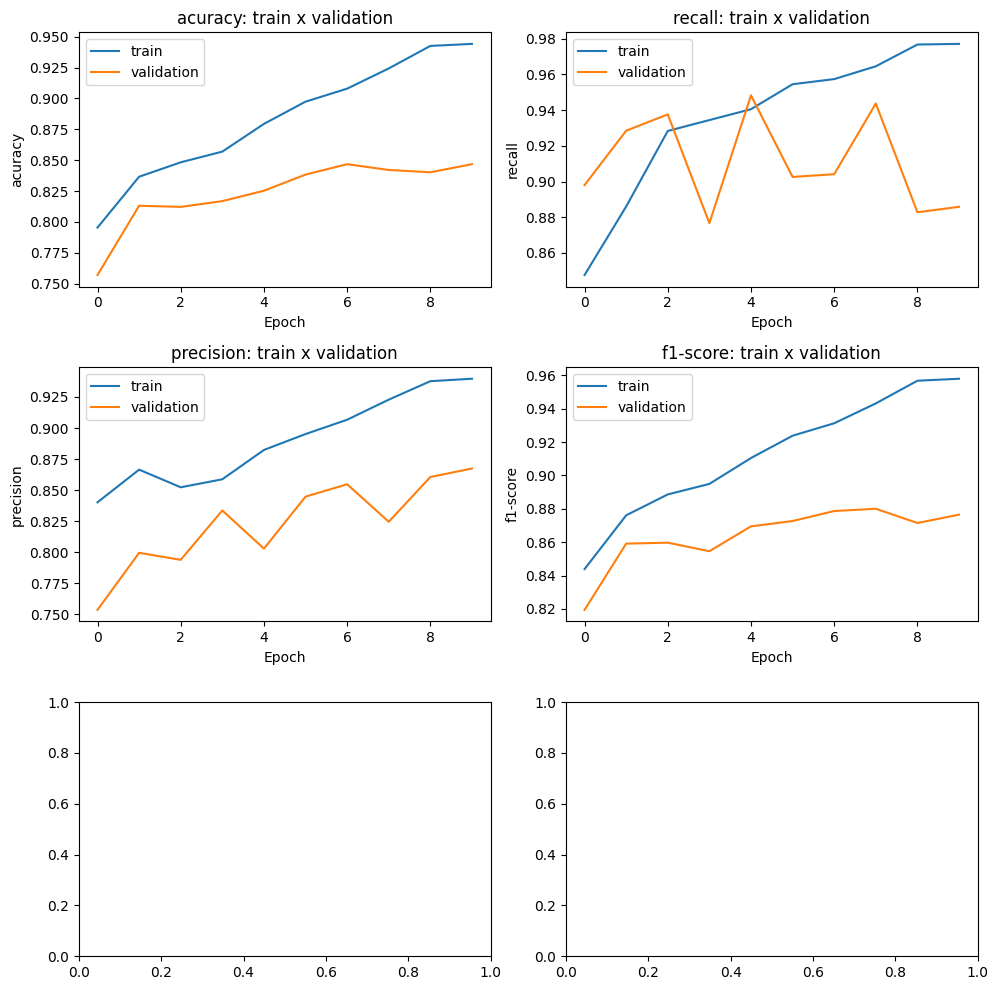

In [16]:
metrics.plot_metrics()

TypeError: 'Axes' object is not subscriptable

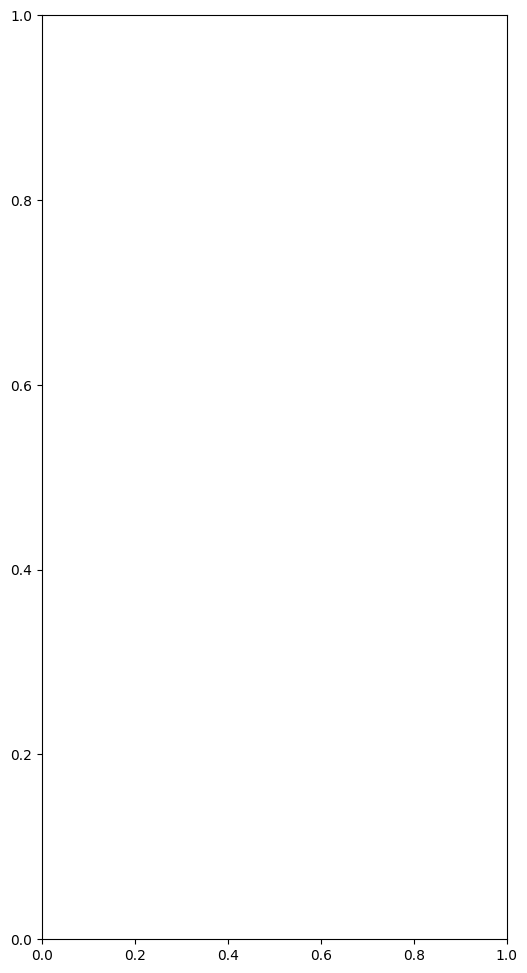

In [18]:
metrics.plot_loss()

In [ ]:
#save all metrics
metrics.save_best_model(all_metrics=True)

In [ ]:
#save only one metric
metrics.save_best_model(all_metrics=False, metric='recall')